# [E-03] Camera Sticker Application
- dlib의 face detection을 사용해 이미지의 얼굴을 검출한다.
- objeck keypoint extimation을 이용해 face landmark localization을 한다. 
    - 이는 face detection의 결과물인 bounding box로 얼굴을 잘라내 사용한다. 
- landmark를 이용해 스티커를 붙일 위치 좌표를 계산한다. 


## 1) load image
- load image
- change bgr to rgb

In [218]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print('import complete !')

import complete !


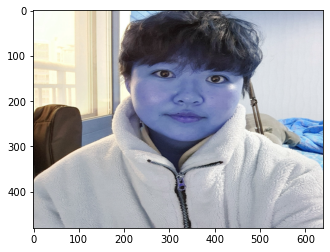

In [234]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/me.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- opencv는 이미지를 BGR로 처리하기 때문에 RGB로 변환한다.

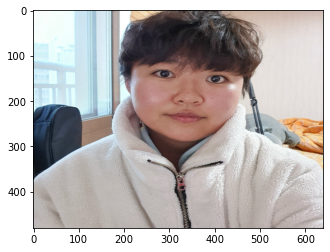

In [235]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2) face detection
- dlib의 face detector사용 

In [236]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print('import complete !')

import complete !


In [237]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[[(216, 68) (439, 291)]]


In [238]:
print(dlib_rects[0].left())
print(dlib_rects[0].top())
print(dlib_rects[0].right())
print(dlib_rects[0].bottom())

216
68
439
291


- 코드 참고   
cv2.rectangle(img, (start point), (end point), line's color, line's thickness, linetype)

216 68
439 291


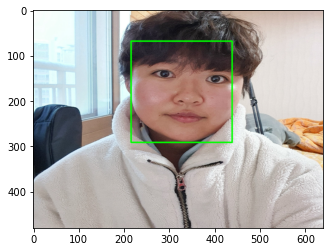

In [239]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l,t)
    print(r,b)

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3) landmark localization
- dlib에서 제공되는 모델의 weight file을 사용한다.
- 위에서 자른 이미지에서 68개의 이목구비 위치를 찾는다.

In [240]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('load model complete !')

load model complete !


In [241]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 68개 이목구비 갯수 확인

68


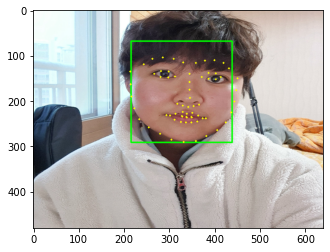

In [242]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4) 스티커의 위치좌표 설정하기
- 고양이 수염 스티커이기 때문에 볼의 좌표를 찾는다.
- 좌표는 랜드마크 좌표로 사용한다.

In [243]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # nose center index : 30
    x = landmark[2][0]
    y = landmark[2][1] #+ dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(217, 190)
(x,y) : (217,190)
(w,h) : (224,224)


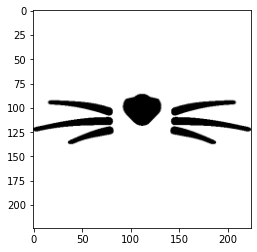

(224, 224, 3)


In [244]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_AREA)
plt.imshow(img_sticker)
plt.show()
print(img_sticker.shape)

In [230]:
refined_x = x              # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (217,78)


- 볼 좌표(x,y)에서 스티커의 박스 크기를 고려해 위치를 설정한다.

In [231]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


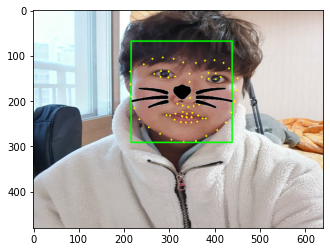

In [232]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

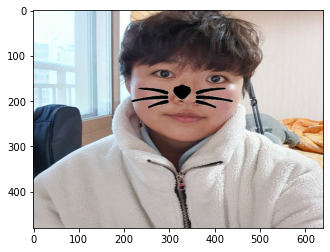

In [233]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- bounding box, landmark를 제거하고 스티커만 입힌 최종 버전
- bounding box가 왼쪽으로 치우쳐져 검출돼 위치가 조금 어긋났지만 코, 볼에 맞는 모습을 볼 수 있다. 

## 5) 스티커 위치 재설정
- 코에 중앙에 오도록 재설정  

In [245]:
refined_x = x + 10              # left
refined_y = y - h//2 + 10       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (227,88)


In [246]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


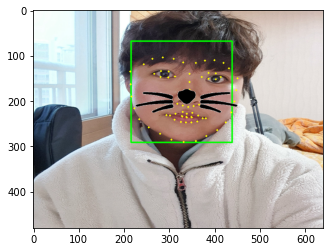

In [247]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

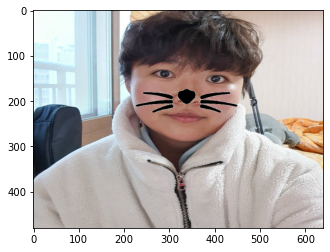

In [248]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 정중앙에 위치하기 성공!

## 6) 밝기, 얼굴각도, 촬영거리가 다른 사진들 테스트
- (1) 밝기가 밝은 사진

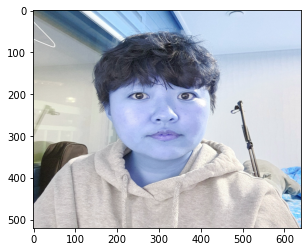

In [442]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bright.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 520))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

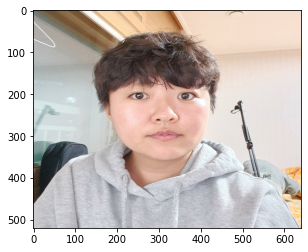

In [443]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [444]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[[(191, 142) (414, 365)]]


- 주위 배경과 밝기가 같아서 그런지 밝기가 밝은 사진은 얼굴 검출이 안된다.    
    => 이미지 사이즈를 변경하니 해결!(기존 640x480보다 키웠다.)

In [445]:
print(dlib_rects[0].left())
print(dlib_rects[0].top())
print(dlib_rects[0].right())
print(dlib_rects[0].bottom())

191
142
414
365


191 142
414 365


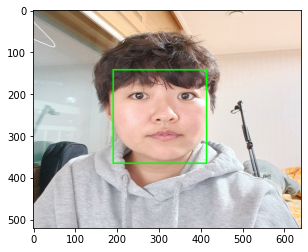

In [446]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l,t)
    print(r,b)

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [447]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 68개 이목구비 갯수 확인

68


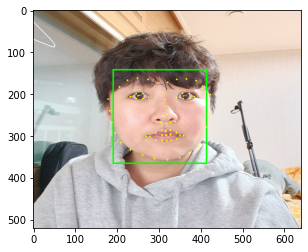

In [448]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [306]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[2]) # nose center index : 30
    x = landmark[2][0]
    y = landmark[2][1] #+ dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(188, 267)
(x,y) : (188,267)
(w,h) : (224,224)


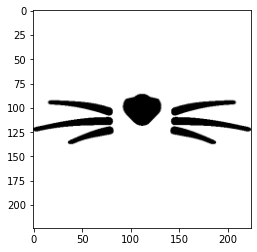

(224, 224, 3)


In [307]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_AREA)
plt.imshow(img_sticker)
plt.show()
print(img_sticker.shape)

In [308]:
refined_x = x + 15 # left
refined_y = y - h//2 - 10      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (203,145)


In [309]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


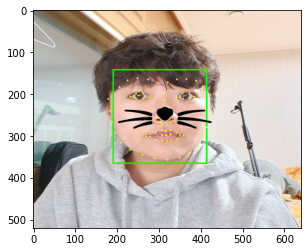

In [310]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

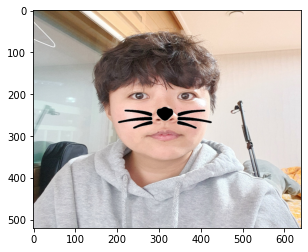

In [311]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 스티커의 좌표 설정
볼 바로 옆 landmark 2번 인덱스를 left-top 좌표로 잡으니 **얼굴 중앙(코)에 위치하지 않는 문제**가 발생했다.   
좌표를 어림잡아 계속 수정하여 위치를 맞췄지만, 확장성이 부족하고 landmark를 사용하는 의미가 없다.  
왼쪽 눈 끝 점(**36 인덱스**)과 볼 옆(**2 인덱스**)의 위치로 left-top 좌표를 다시 설정하고자 한다.

In [325]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[2]) # left cheek index : 2
    print(landmark[36])
    m = landmark[36][0]
    n = landmark[36][1]
    x = landmark[2][0] 
    y = landmark[2][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    x = x + (m-x)    
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(188, 267)
(232, 206)
(x,y) : (232,267)
(w,h) : (224,224)


In [326]:
refined_x = x              # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (232,155)


In [327]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


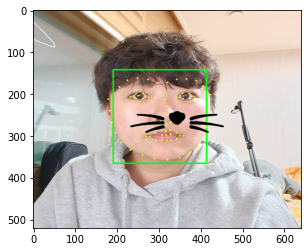

In [328]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 2, 36 인덱스를 사용하니 오른쪽으로 과하게 치우쳐졌다.   
- 턱 쪽 인덱스 2, 4 인덱스를 이용해서 다시 시도!

In [337]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[2]) # left cheek index : 2
    print(landmark[4])
    m = landmark[4][0]
    n = landmark[4][1]
    x = landmark[2][0] 
    y = landmark[2][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    x = x + (m-x)    
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(188, 267)
(209, 316)
(x,y) : (209,267)
(w,h) : (224,224)


In [338]:
refined_x = x              # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (209,155)


In [339]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


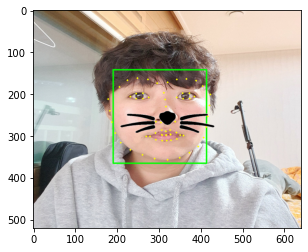

In [340]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 이번엔 너무 아래쪽이어서, 2번 인덱스가 아닌 1, 4 인덱스를 사용해서 다시 도전!

In [348]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[1]) # left cheek index : 2
    print(landmark[4])
    m = landmark[4][0]
    n = landmark[4][1]
    x = landmark[1][0] 
    y = landmark[1][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    x = x + (m-x)    
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(183, 240)
(209, 316)
(x,y) : (209,240)
(w,h) : (224,224)


In [349]:
refined_x = x              # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (209,128)


In [350]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

(224, 224, 3)


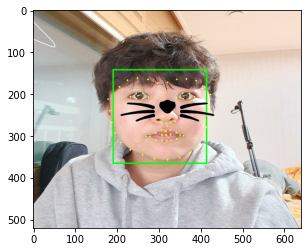

In [351]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 이번에도 애매한 위치
- 이번엔 코로 중간 지점을 잡아서 그 left-top 지점을 너비로 조절해본다.

In [449]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index : 30
    print(landmark[33]) # nose point index : 33
    m = landmark[30][0]
    n = landmark[30][1]
    x = landmark[33][0] 
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    x = x - (x-m)
    y = y - ((y-n)//2)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(320, 248)
(317, 270)
(x,y) : (320,259)
(w,h) : (224,224)


In [450]:
refined_x = x - h//2       # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (208,147)


(224, 224, 3)


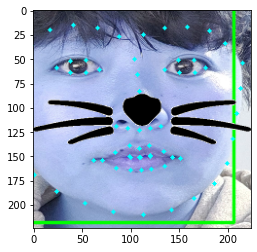

In [451]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

# sticker_area를 출력해 확인한다.
plt.imshow(sticker_area)
plt.show()

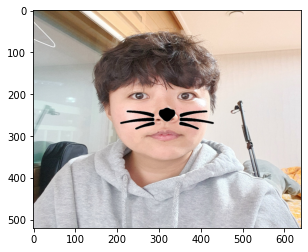

In [431]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 각 landmark 인덱스 좌표를 이용해서 계산하니 위치를 잡을 수 있었다. 
- 다른 사진에도 동일 좌표를 적용시켜 확인해보겠다. 

(2) 거리가 먼 사진

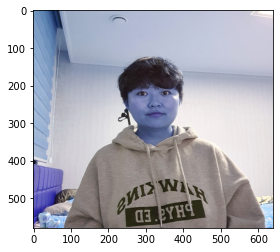

In [488]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/distance.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 580))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

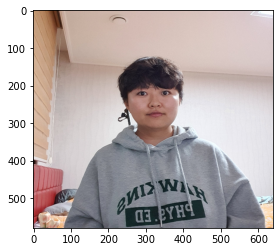

In [489]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [490]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[[(253, 182) (382, 311)]]


In [491]:
print(dlib_rects[0].left())
print(dlib_rects[0].top())
print(dlib_rects[0].right())
print(dlib_rects[0].bottom())

253
182
382
311


253 182
382 311


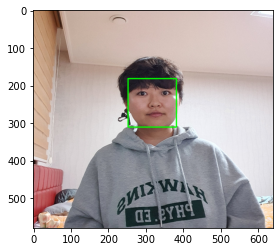

In [492]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    print(l,t)
    print(r,b)

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [493]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 68개 이목구비 갯수 확인

68


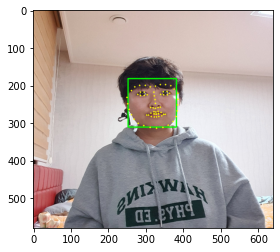

In [494]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [495]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index : 30
    print(landmark[33]) # nose point index : 33
    m = landmark[30][0]
    n = landmark[30][1]
    x = landmark[33][0] 
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    x = x - (x-m)
    y = y - ((y-n)//2)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(326, 248)
(326, 261)
(x,y) : (326,255)
(w,h) : (130,130)


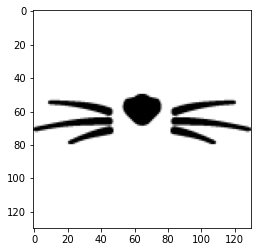

(130, 130, 3)


In [497]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h), interpolation=cv2.INTER_AREA)
plt.imshow(img_sticker)
plt.show()
print(img_sticker.shape)

In [498]:
refined_x = x - h//2       # left
refined_y = y - h//2       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (261,190)


(130, 130, 3)


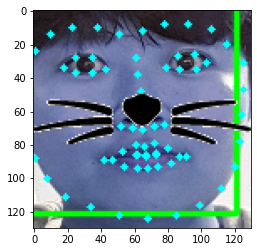

In [499]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print(sticker_area.shape)

# sticker_area를 출력해 확인한다.
plt.imshow(sticker_area)
plt.show()

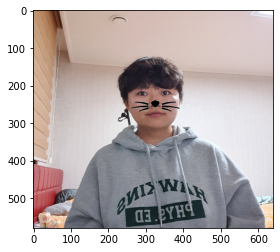

In [500]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 적용 성공!      

(3) 얼굴 각도가 정면이 아닌 사진

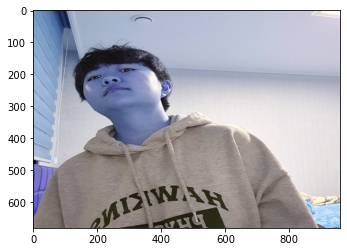

In [519]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/viewpoint.jpg'
img_bgr = cv2.imread(my_image_path)        #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (960, 680))  # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

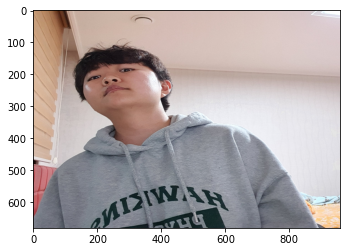

In [520]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [528]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[]


- 아무리 키워도 얼굴이 너무 안나와서 검출이 안된다.    

(4) 전신 사진

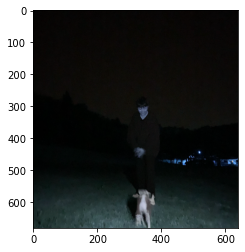

In [525]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/full.jpg'
img_bgr = cv2.imread(my_image_path)        #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 680))  # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

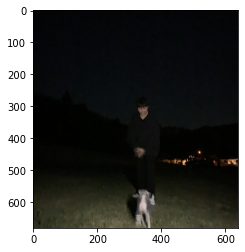

In [526]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [527]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)  # 검출한 얼굴 영역 좌표

rectangles[]


- 너무 얼굴이 작아서 검출이 되지 않는다.

# 프로젝트 정리
---
1. 이미지를 opencv로 load하고, rgb로 변경한다.  
    - opencv로 load한 이미지는 bgr이기 때문에, 이를 rgb로 바꾼다. 
2. dlib의 face detector를 선언하고, 해당 이미지에 적용해 얼굴 영역을 검출한다.
3. dlib에서 제공되는 landmark localization 모델 weight를 사용한다.    
    - 68개의 포인트로 이목구비를 마킹한다.
4. landmark 좌표를 통해 스티커를 붙일 위치좌표를 계산한다.  
    - 각 좌표를 이용해 비율로 계산하였다. 

# 루브릭 평가
---
1. **자기만의 카메라앱 기능 구현을 완수하였다.**        

    - 위 *#프로젝트 정리*과정을 통해 고양이 수염 스티커를 얼굴에 붙이는 기능을 구현했다.    
    
    
2. **스티커 이미지를 정확한 원본 위치에 반영하였다.**  

    - 고양이 수염 이미지 전체의 크기를 고려해야 원하는 위치에 스티커를 붙일 수 있었다.   
    - 처음에는 사진의 좌표를 가늠해 상수로 계산했으나, 이 방법은 여러 사진에 적용할 수 없었다.  
    - 다른 여러 사진에도 적용이 가능하도록 landmark의 비율을 고려해 계산했고, 원하는 위치에 적용할 수 있었다.
    
    
3. **카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.**

    - 밝기, 거리를 다르게 한 이미지에는 이미지를 불러올 때 크기를 키우면 적용이 가능했다.    
    - 하지만, 너무 먼 사진(전신사진)이나 얼굴의 정면이 아닌 사진은 얼굴을 detection하지 못했다.   
    - 이런 이미지들은 얼굴 부분만 이미지를 crop한 후에 스티커를 붙이고, 붙인 이미지를 원본 이미지 위에 덮어씌워야할 것이라고 생각한다.   
  
# 회고
--- 
## 새롭게 알게된(혹은 다시 정립한)개념
- np.where, 스티커를 붙이는 방식   
    : 스티커를 원본 이미지 위에 올려 같이 출력하는 것이 아니라, 해당 스티커가 있는 영역을 잡고 그 영역 내에서 스티커의 색을 기준으로 해당 색이 있으면 스티커의 픽셀을, 없으면 원본 이미지 픽셀을 출력하는 방식이다.

- landmark를 사용해서 어플의 확장성을 갖춘다.   
    : landmark를 사용해 스티커가 위치할 좌표를 계산하면 모든 사진에 동일한 위치에 스티커를 입힐 수 있다. 
    
## 느낀 점  
좌표를 계산 후 적용하는 부분의 이해가 처음엔 어려웠지만, 이미지 축을 이해하니 개념을 확립할 수 있었다. 또한 스티커의 픽셀과 원본 이미지 픽셀을 동시에 같이 출력하는 부분도 인상깊었다. 하지만 적용할 수 있는 이미지의 기준이 있어서, 그 한계점을 해결하지 못한 점이 아쉬웠다. 실제 카메라 어플리케이션은 화면을 비추면서 기능이 구현되기 때문에 영상에도 적용해보고 싶다.